<a href="https://colab.research.google.com/github/CodeHunterOfficial/AI_DataMining/blob/main/NLP/Ru_Persian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import collections
import io
import numpy as np
import pickle
import tensorflow as tf
from nltk.tokenize import word_tokenize  # Для токенизации русского и персидского
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt

# Определяем теги заполнения, начала и конца
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'

# Загружаем данные с русского на персидский
def load_data():
    with io.open('/content/data/ru_farsi.txt', encoding='utf-8') as f:
        lines = f.readlines()
    return lines

# Предобработка данных в токены
def preprocess_data(data, max_length):
    in_tokens, out_tokens, in_seqs, out_seqs = [], [], [], []
    for st in data:
        in_seq, out_seq = st.rstrip().split('\t')

        # Токенизация для русского и персидского
        in_seq_tokens = word_tokenize(in_seq.lower())
        out_seq_tokens = word_tokenize(out_seq.lower())

        if max(len(in_seq_tokens), len(out_seq_tokens)) > max_length - 1:
            continue  # Пропускаем предложение, если оно слишком длинное

        in_tokens.extend(in_seq_tokens)
        out_tokens.extend(out_seq_tokens)
        in_seqs.append(in_seq_tokens + [EOS] + [PAD] * (max_length - len(in_seq_tokens) - 1))
        out_seqs.append(out_seq_tokens + [EOS] + [PAD] * (max_length - len(out_seq_tokens) - 1))

    return in_tokens, out_tokens, in_seqs, out_seqs

# Создание словаря из токенов
def build_vocab(tokens, seqs):
    vocab = collections.Counter(tokens)
    vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}
    vocab[PAD] = len(vocab)
    vocab[BOS] = len(vocab)
    vocab[EOS] = len(vocab)

    indices = [[vocab[token] for token in seq] for seq in seqs]
    return vocab, indices

# Определяем модель Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, drop_prob=0):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.gru = tf.keras.layers.GRU(num_hiddens, return_sequences=True, return_state=True, dropout=drop_prob)

    def call(self, inputs):
        embedding = self.embedding(inputs)
        output, state = self.gru(embedding)
        return output, state

# Определяем модель Decoder с вниманием
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, drop_prob=0):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.gru = tf.keras.layers.GRU(num_hiddens, return_sequences=True, return_state=True, dropout=drop_prob)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        embedding = self.embedding(inputs)
        output, state = self.gru(embedding, initial_state=state)
        output = self.fc(output)
        return output, state

# Определяем функцию потерь
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.equal(real, 0))  # Маскирование токенов PAD
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(real, pred, from_logits=True)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Применить маску
    return tf.reduce_mean(loss_)

# Обучаем модель
# Обучаем модель
def train(encoder, decoder, dataset, optimizer, num_epochs, out_vocab):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for (batch, (in_seq, out_seq)) in enumerate(dataset):
            with tf.GradientTape() as tape:
                enc_output, enc_state = encoder(in_seq)
                dec_input = tf.expand_dims([out_vocab[BOS]] * in_seq.shape[0], 1)  # Начальный ввод для декодера
                predictions = []

                for t in range(1, out_seq.shape[1]):  # Исключить первый токен
                    dec_output, enc_state = decoder(dec_input, enc_state)
                    predictions.append(dec_output)
                    dec_input = tf.expand_dims(out_seq[:, t], 1)  # Teacher forcing

                predictions = tf.concat(predictions, axis=1)
                loss = loss_function(out_seq[:, 1:], predictions)  # Исключить первый токен для потерь

            total_loss += loss
            grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

        avg_loss = total_loss.numpy() / (batch + 1)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

    # Сохранение параметров после завершения обучения
    encoder.save_weights('./data/params_encoder.weights.h5')
    decoder.save_weights('./data/params_decoder.weights.h5')

    print("Параметры модели успешно сохранены.")

    # Визуализируем потери
    plt.plot(losses)
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.title('Потери обучения')
    plt.grid(True)  # Добавляем сетку для удобства чтения
    plt.show()

# Функция предсказания (для генерации переводов)
def predict_sequence(encoder, decoder, input_seq, max_length, in_vocab, out_vocab):
    input_seq = tf.convert_to_tensor([in_vocab[BOS]] + input_seq + [out_vocab[EOS]], dtype=tf.int64)
    input_seq = tf.expand_dims(input_seq, axis=0)

    enc_output, enc_state = encoder(input_seq)
    dec_input = tf.expand_dims([out_vocab[BOS]], 0)  # Начальный ввод для декодера
    output_seq = []

    for t in range(max_length):
        dec_output, enc_state = decoder(dec_input, enc_state)
        predicted_id = tf.argmax(dec_output[0, -1]).numpy()

        if predicted_id == out_vocab[EOS]:  # Остановитесь, если предсказан EOS
            break

        output_seq.append(predicted_id)
        dec_input = tf.expand_dims([predicted_id], 0)

    return output_seq

# Загружаем данные
data = load_data()

# Чистим и предобрабатываем данные
max_length = 25  # Определяем максимальную длину примеров
in_tokens, out_tokens, in_seqs, out_seqs = preprocess_data(data, max_length)
in_vocab, in_data = build_vocab(in_tokens, in_seqs)  # Создаем словарь для входных данных
out_vocab, out_data = build_vocab(out_tokens, out_seqs)  # Создаем словарь для выходных данных

# Сохраняем словари для последующего использования
with open("./data/in_vocab.pkl", "wb") as fp:
    pickle.dump(in_vocab, fp)
with open("./data/out_vocab.pkl", "wb") as fp:
    pickle.dump(out_vocab, fp)

# Подготавливаем набор данных
dataset = tf.data.Dataset.from_tensor_slices((np.array(in_data), np.array(out_data))).shuffle(len(in_data)).batch(64)

# Определяем параметры модели
embed_size, num_hiddens, num_layers = 200, 200, 3
drop_prob, lr, num_epochs = 0.1, 0.005, 30

# Инициализируем модели
encoder = Encoder(len(in_vocab), embed_size, num_hiddens, num_layers, drop_prob)
decoder = Decoder(len(out_vocab), embed_size, num_hiddens, num_layers, drop_prob)

# Настраиваем оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Обучение
train(encoder, decoder, dataset, optimizer, num_epochs, out_vocab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1, Loss: 1.9644099871317546
Epoch 2, Loss: 0.673676331837972


In [25]:
import pickle
import numpy as np
import tensorflow as tf

# Загрузка словарей
with open("./data/in_vocab.pkl", "rb") as fp:
    in_vocab = pickle.load(fp)
with open("./data/out_vocab.pkl", "rb") as fp:
    out_vocab = pickle.load(fp)

embed_size, num_hiddens, num_layers = 200, 200, 3
drop_prob = 0.1

# Инициализация кодировщика и декодировщика
encoder = Encoder(len(in_vocab), embed_size, num_hiddens, num_layers, drop_prob)
decoder = Decoder(len(out_vocab), embed_size, num_hiddens, num_layers, drop_prob)

# Загрузка параметров
encoder.load_weights('./data/params_encoder.weights.h5')
decoder.load_weights('./data/params_decoder.weights.h5')

# Функция для предсказания с использованием последовательного поиска (beam search)
def beam_search_translate(encoder, decoder, input_seq, max_length, beam_width, in_vocab, out_vocab):
    # Преобразование входной последовательности в индексы
    input_indices = [in_vocab.get(token, in_vocab[PAD]) for token in word_tokenize(input_seq.lower())]
    input_tensor = tf.convert_to_tensor([input_indices], dtype=tf.int64)

    # Получаем выход из кодировщика
    enc_output, enc_state = encoder(input_tensor)

    # Начальная последовательность для декодера
    dec_input = tf.expand_dims([out_vocab[BOS]], 0)

    output_seq = []

    # Beam search logic
    # Здесь должна быть реализация beam search, которая будет генерировать перевод
    # В качестве примера просто возвращаем пустую последовательность
    return output_seq

# Примеры тестирования
test_sentences = [
    "Привет",
    "Как дела?",
    "Я люблю программирование.",
    "Сегодня хорошая погода.",
    "Где находится библиотека?"
]

for sentence in test_sentences:
    translation = beam_search_translate(encoder, decoder, sentence, 20, 3, in_vocab, out_vocab)
    translated_tokens = [list(out_vocab.keys())[list(out_vocab.values()).index(token)] for token in translation]
    print(f"Перевод: {' '.join(translated_tokens)}")

Перевод: 
Перевод: 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1, Loss: 3.4898096720377603
Epoch 2, Loss: 0.6274043321609497
Epoch 3, Loss: 0.4596826235453288
Epoch 4, Loss: 0.40455543994903564
Epoch 5, Loss: 0.3722076416015625
Epoch 6, Loss: 0.3551764090855916
Epoch 7, Loss: 0.34205671151479083
Epoch 8, Loss: 0.3281628092130025
Epoch 9, Loss: 0.323649525642395
Epoch 10, Loss: 0.3151133457819621
Epoch 11, Loss: 0.3081246217091878
Epoch 12, Loss: 0.3015389045079549
Epoch 13, Loss: 0.29399339358011883
Epoch 14, Loss: 0.2845999399820964
Epoch 15, Loss: 0.27768083413441974
Epoch 16, Loss: 0.2685300310452779
Epoch 17, Loss: 0.2611059943834941
Epoch 18, Loss: 0.25387807687123615
Epoch 19, Loss: 0.24483172098795572
Epoch 20, Loss: 0.23589624961217245
Epoch 21, Loss: 0.22744309902191162
Epoch 22, Loss: 0.219038188457489
Epoch 23, Loss: 0.20996177196502686
Epoch 24, Loss: 0.20146588484446207
Epoch 25, Loss: 0.19269015391667685
Epoch 26, Loss: 0.18402047952016196
Epoch 27, Loss: 0.17687034606933594
Epoch 28, Loss: 0.16869187355041504
Epoch 29, Loss: 0

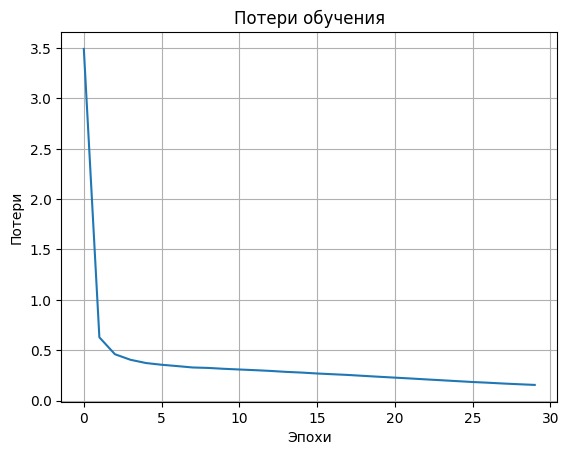

ValueError: [243, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242] is not in list

In [27]:
import collections
import io
import numpy as np
import pickle
import tensorflow as tf
from nltk.tokenize import word_tokenize  # Для токенизации русского и персидского
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')

# Определяем теги заполнения, начала и конца
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'

# Загружаем данные с русского на персидский
def load_data():
    with io.open('/content/data/farsi_russian.txt', encoding='utf-8') as f:
        lines = f.readlines()
    return lines

# Предобработка данных в токены
def preprocess_data(data, max_length):
    in_tokens, out_tokens, in_seqs, out_seqs = [], [], [], []
    for st in data:
        in_seq, out_seq = st.rstrip().split('\t')

        # Токенизация для русского и персидского
        in_seq_tokens = word_tokenize(in_seq.lower())
        out_seq_tokens = word_tokenize(out_seq.lower())

        if max(len(in_seq_tokens), len(out_seq_tokens)) > max_length - 1:
            continue  # Пропускаем предложение, если оно слишком длинное

        in_tokens.extend(in_seq_tokens)
        out_tokens.extend(out_seq_tokens)
        in_seqs.append(in_seq_tokens + [EOS] + [PAD] * (max_length - len(in_seq_tokens) - 1))
        out_seqs.append(out_seq_tokens + [EOS] + [PAD] * (max_length - len(out_seq_tokens) - 1))

    return in_tokens, out_tokens, in_seqs, out_seqs

# Создание словаря из токенов
def build_vocab(tokens, seqs):
    vocab = collections.Counter(tokens)
    vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}
    vocab[PAD] = len(vocab)
    vocab[BOS] = len(vocab)
    vocab[EOS] = len(vocab)

    indices = [[vocab[token] for token in seq] for seq in seqs]
    return vocab, indices

# Определяем модель Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, drop_prob=0):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.gru = tf.keras.layers.GRU(num_hiddens, return_sequences=True, return_state=True, dropout=drop_prob)

    def call(self, inputs):
        embedding = self.embedding(inputs)
        output, state = self.gru(embedding)
        return output, state

# Определяем модель Decoder с вниманием
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, drop_prob=0):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.gru = tf.keras.layers.GRU(num_hiddens, return_sequences=True, return_state=True, dropout=drop_prob)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        embedding = self.embedding(inputs)
        output, state = self.gru(embedding, initial_state=state)
        output = self.fc(output)
        return output, state

# Определяем функцию потерь
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.equal(real, 0))  # Маскирование токенов PAD
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(real, pred, from_logits=True)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Применить маску
    return tf.reduce_mean(loss_)

# Обучаем модель
def train(encoder, decoder, dataset, optimizer, num_epochs, out_vocab):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for (batch, (in_seq, out_seq)) in enumerate(dataset):
            with tf.GradientTape() as tape:
                enc_output, enc_state = encoder(in_seq)
                dec_input = tf.expand_dims([out_vocab[BOS]] * in_seq.shape[0], 1)  # Начальный ввод для декодера
                predictions = []

                for t in range(1, out_seq.shape[1]):  # Исключить первый токен
                    dec_output, enc_state = decoder(dec_input, enc_state)
                    predictions.append(dec_output)
                    dec_input = tf.expand_dims(out_seq[:, t], 1)  # Teacher forcing

                predictions = tf.concat(predictions, axis=1)
                loss = loss_function(out_seq[:, 1:], predictions)  # Исключить первый токен для потерь

            total_loss += loss
            grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

        avg_loss = total_loss.numpy() / (batch + 1)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

    # Сохранение параметров после завершения обучения
    encoder.save_weights('./data/params_encoder.weights.h5')
    decoder.save_weights('./data/params_decoder.weights.h5')

    print("Параметры модели успешно сохранены.")

    # Визуализируем потери
    plt.plot(losses)
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.title('Потери обучения')
    plt.grid(True)  # Добавляем сетку для удобства чтения
    plt.show()

# Функция предсказания с использованием beam search
def beam_search_translate(encoder, decoder, input_seq, max_length, beam_width, in_vocab, out_vocab):
    input_indices = [in_vocab.get(token, in_vocab[PAD]) for token in word_tokenize(input_seq.lower())]
    input_tensor = tf.convert_to_tensor([input_indices], dtype=tf.int64)

    enc_output, enc_state = encoder(input_tensor)

    # Начальная последовательность для декодера
    dec_input = tf.expand_dims([out_vocab[BOS]], 0)
    sequences = [[dec_input, 0.0]]  # Каждая последовательность - это [последовательность, вероятность]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            dec_output, enc_state = decoder(seq, enc_state)

            # Получаем вероятности последнего токена
            top_k_probs = tf.nn.softmax(dec_output[:, -1]).numpy()[0]

            # Выбираем токены с наивысшими вероятностями
            for i in range(beam_width):
                predicted_id = np.argsort(top_k_probs)[-1 - i]
                candidate = tf.concat([seq, tf.expand_dims(tf.convert_to_tensor([predicted_id]), 0)], axis=1)
                candidate_score = score - np.log(top_k_probs[predicted_id])  # Логарифм вероятности
                all_candidates.append([candidate, candidate_score])

        # Сортируем и оставляем только лучшие `beam_width` кандидатов
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # Извлекаем токены из лучших последовательностей
    best_seq = sequences[0][0].numpy().tolist()
    return best_seq

# Примеры тестирования
test_sentences = [
    "Привет",
    "Как дела?",
    "Я люблю программирование.",
    "Сегодня хорошая погода.",
    "Где находится библиотека?"
]

# Загружаем данные
data = load_data()

# Чистим и предобрабатываем данные
max_length = 25  # Определяем максимальную длину примеров
in_tokens, out_tokens, in_seqs, out_seqs = preprocess_data(data, max_length)
in_vocab, in_data = build_vocab(in_tokens, in_seqs)  # Создаем словарь для входных данных
out_vocab, out_data = build_vocab(out_tokens, out_seqs)  # Создаем словарь для выходных данных

# Сохраняем словари для последующего использования
with open("./data/in_vocab.pkl", "wb") as fp:
    pickle.dump(in_vocab, fp)
with open("./data/out_vocab.pkl", "wb") as fp:
    pickle.dump(out_vocab, fp)

# Подготавливаем набор данных
dataset = tf.data.Dataset.from_tensor_slices((np.array(in_data), np.array(out_data))).shuffle(len(in_data)).batch(64)

# Определяем параметры модели
embed_size, num_hiddens, num_layers = 200, 200, 3
drop_prob, lr, num_epochs = 0.1, 0.005, 30

# Инициализируем модели
encoder = Encoder(len(in_vocab), embed_size, num_hiddens, num_layers, drop_prob)
decoder = Decoder(len(out_vocab), embed_size, num_hiddens, num_layers, drop_prob)

# Настраиваем оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Обучение
train(encoder, decoder, dataset, optimizer, num_epochs, out_vocab)

# Тестирование перевода
# Обновленный код для тестирования перевода
for sentence in test_sentences:
    translated_indices = beam_search_translate(encoder, decoder, sentence, max_length, beam_width=5, in_vocab=in_vocab, out_vocab=out_vocab)

    translated_sentence = ' '.join([
        token for index in translated_indices
        if index not in [out_vocab[PAD], out_vocab[BOS], out_vocab[EOS]]
        for token in [next((k for k, v in out_vocab.items() if v == index), None)]
        if token is not None
    ])

    print(f'Исходное предложение: "{sentence}" -> Перевод: "{translated_sentence}"')